# 05.4 Omitted Variable Bias

**Chapter**: 5 - The Unreasonable Effectiveness of Linear Regression  
**Section**: 4 - Omitted Variable or Confounding Bias  
**Facure Source**: 05-The-Unreasonable-Effectiveness-of-Linear-Regression.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [The Angrist Mantra](#11-the-angrist-mantra)
   - 1.2 [Confounders and DAGs](#12-confounders-and-dags)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [The OVB Formula](#21-the-ovb-formula)
   - 2.2 [Proof of OVB Formula](#22-proof-of-ovb-formula)
   - 2.3 [Sign of Bias](#23-sign-of-bias)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Simulating OVB](#31-simulating-ovb)
   - 3.2 [Verifying the Formula](#32-verifying-the-formula)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    TUFTE_PALETTE,
)
import statsmodels.formula.api as smf

set_notebook_style()
np.random.seed(42)

---

## 1. Facure's Intuition

> **Interview Relevance**: The OVB formula is one of the most-asked concepts in econometrics interviews. You should be able to derive it, interpret the sign, and give examples.

### 1.1 The Angrist Mantra

Facure highlights Joshua Angrist's famous mantra for remembering OVB:

> **"Short equals long plus the effect of omitted times the regression of omitted on included."**

In symbols, if the true model is:

$$Y = \beta_0 + \kappa T + \gamma A + \epsilon$$

But we estimate the "short" regression (omitting $A$):

$$Y = \beta_0 + \hat{\kappa}_{short} T + e$$

Then:

$$\hat{\kappa}_{short} = \kappa + \gamma \cdot \delta$$

where $\delta$ is the coefficient from regressing $A$ on $T$.

### 1.2 Confounders and DAGs

**Confounder**: A variable that causes both the treatment and the outcome.

Facure's examples:

**Example 1: Education → Wages (positive bias)**
- IQ → Education (positive)
- IQ → Wages (positive)
- Bias = (+)(+) = positive → overestimate education effect

**Example 2: Police → Violence (negative bias)**
- Crime → Police (positive)
- Crime → Violence (positive)
- But Police → Violence might be negative
- Omitting Crime causes bias that makes police look harmful

★ Insight ─────────────────────────────────────
- Bias = 0 if omitted doesn't affect outcome (γ = 0)
- Bias = 0 if omitted uncorrelated with treatment (δ = 0, as in RCT!)
- Sign of bias = sign(γ) × sign(δ)
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 The OVB Formula

**Theorem (Omitted Variable Bias)**:

Let the true data-generating process be:

$$Y_i = \beta_0 + \kappa T_i + \gamma A_i + \epsilon_i$$

where $E[\epsilon | T, A] = 0$.

If we estimate the "short" regression omitting $A$:

$$Y_i = \tilde{\beta}_0 + \tilde{\kappa} T_i + u_i$$

Then:

$$\boxed{\text{plim } \tilde{\kappa} = \kappa + \gamma \cdot \delta}$$

where $\delta = \frac{\text{Cov}(A, T)}{\text{Var}(T)}$ is the population coefficient from regressing $A$ on $T$.

### 2.2 Proof of OVB Formula

**Proof**:

The short regression coefficient (in population) is:

$$\tilde{\kappa} = \frac{\text{Cov}(Y, T)}{\text{Var}(T)}$$

Substitute $Y = \beta_0 + \kappa T + \gamma A + \epsilon$:

$$\tilde{\kappa} = \frac{\text{Cov}(\kappa T + \gamma A + \epsilon, T)}{\text{Var}(T)}$$

Since $\text{Cov}(\epsilon, T) = 0$ by assumption:

$$= \frac{\kappa \text{Var}(T) + \gamma \text{Cov}(A, T)}{\text{Var}(T)}$$

$$= \kappa + \gamma \cdot \frac{\text{Cov}(A, T)}{\text{Var}(T)}$$

$$= \kappa + \gamma \cdot \delta \quad \blacksquare$$

### 2.3 Sign of Bias

The bias term $\gamma \cdot \delta$ has sign equal to:

$$\text{sign}(\text{Bias}) = \text{sign}(\gamma) \times \text{sign}(\delta)$$

| $\gamma$ (omitted → Y) | $\delta$ (omitted ↔ T) | Bias direction |
|:----------------------:|:----------------------:|:--------------:|
| + | + | Positive (overestimate) |
| + | − | Negative (underestimate) |
| − | + | Negative (underestimate) |
| − | − | Positive (overestimate) |

---

## 3. Numeric Demonstration

### 3.1 Simulating OVB

In [2]:
# Simulate data with known DGP
n = 5000

# True parameters
kappa_true = 2.0    # True effect of T on Y
gamma_true = 3.0    # Effect of confounder A on Y
delta_true = 0.5    # Correlation of A with T

# Generate data
# Confounder A (unobserved in short regression)
A = np.random.normal(0, 1, n)

# Treatment T (correlated with A)
T = delta_true * A + np.random.normal(0, np.sqrt(1 - delta_true**2), n)

# Outcome Y
epsilon = np.random.normal(0, 1, n)
Y = kappa_true * T + gamma_true * A + epsilon

sim_data = pd.DataFrame({'Y': Y, 'T': T, 'A': A})

print("Simulated DGP")
print("="*50)
print(f"True κ (T → Y):        {kappa_true}")
print(f"True γ (A → Y):        {gamma_true}")
print(f"True δ (A ~ T):        {delta_true}")
print(f"Expected bias:         {gamma_true * delta_true}")
print(f"Expected short coef:   {kappa_true + gamma_true * delta_true}")

Simulated DGP
True κ (T → Y):        2.0
True γ (A → Y):        3.0
True δ (A ~ T):        0.5
Expected bias:         1.5
Expected short coef:   3.5


In [3]:
# Long regression (includes confounder)
model_long = smf.ols('Y ~ T + A', data=sim_data).fit()

print("Long Regression (includes A)")
print(f"  κ̂ (T):  {model_long.params['T']:.4f}  (true: {kappa_true})")
print(f"  γ̂ (A):  {model_long.params['A']:.4f}  (true: {gamma_true})")

Long Regression (includes A)
  κ̂ (T):  1.9934  (true: 2.0)
  γ̂ (A):  3.0005  (true: 3.0)


In [4]:
# Short regression (omits confounder)
model_short = smf.ols('Y ~ T', data=sim_data).fit()

print("Short Regression (omits A)")
print(f"  κ̃ (T):  {model_short.params['T']:.4f}  (expected: {kappa_true + gamma_true * delta_true})")

Short Regression (omits A)
  κ̃ (T):  3.4602  (expected: 3.5)


In [5]:
# Auxiliary regression (A on T)
model_aux = smf.ols('A ~ T', data=sim_data).fit()

print("Auxiliary Regression (A ~ T)")
print(f"  δ̂:     {model_aux.params['T']:.4f}  (true: {delta_true})")

Auxiliary Regression (A ~ T)
  δ̂:     0.4888  (true: 0.5)


### 3.2 Verifying the Formula

In [6]:
# Verify OVB formula
kappa_long = model_long.params['T']
gamma_hat = model_long.params['A']
delta_hat = model_aux.params['T']
kappa_short = model_short.params['T']

# Formula: short = long + gamma * delta
kappa_predicted = kappa_long + gamma_hat * delta_hat

print("OVB Formula Verification")
print("="*50)
print(f"Short coefficient:                {kappa_short:.6f}")
print(f"Long + γ·δ (formula prediction):  {kappa_predicted:.6f}")
print(f"")
print(f"Difference: {abs(kappa_short - kappa_predicted):.2e}")
print(f"Match: {np.isclose(kappa_short, kappa_predicted, rtol=1e-6)}")

# Verify to reasonable precision (finite sample)
assert np.isclose(kappa_short, kappa_predicted, rtol=1e-6)

OVB Formula Verification
Short coefficient:                3.460169
Long + γ·δ (formula prediction):  3.460169

Difference: 4.44e-15
Match: True


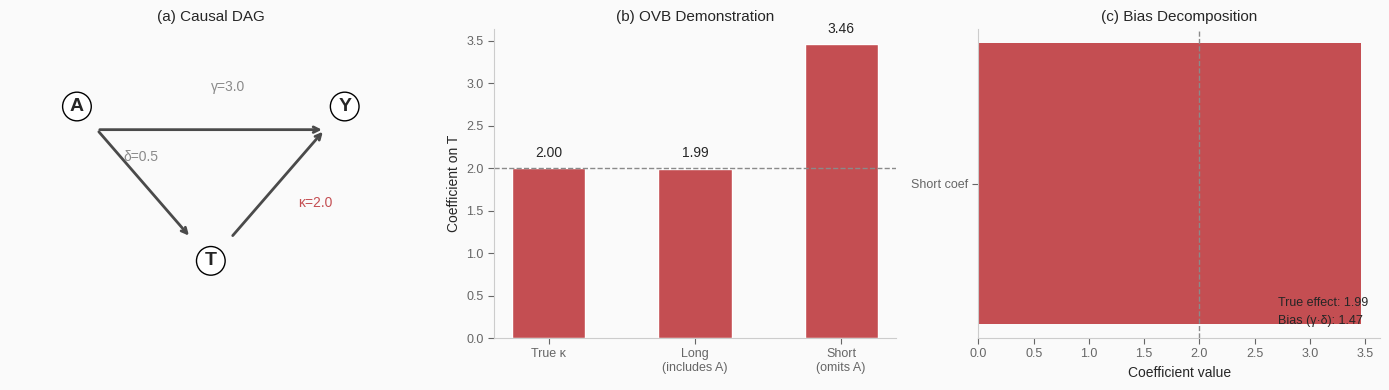

In [7]:
# Visualize the bias
fig, axes = create_tufte_figure(1, 3, figsize=(14, 4))

# Panel 1: DAG representation
ax = axes[0]
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)

# Draw nodes
node_style = dict(ha='center', va='center', fontsize=14, fontweight='bold',
                  bbox=dict(boxstyle='circle,pad=0.3', facecolor='white', edgecolor='black'))
ax.text(0, 1, 'A', **node_style)
ax.text(1, 0, 'T', **node_style)
ax.text(2, 1, 'Y', **node_style)

# Draw edges
arrow_style = dict(arrowstyle='->', color=TUFTE_PALETTE['primary'], lw=2)
ax.annotate('', xy=(0.85, 0.15), xytext=(0.15, 0.85), arrowprops=arrow_style)
ax.annotate('', xy=(1.85, 0.85), xytext=(0.15, 0.85), arrowprops=arrow_style)
ax.annotate('', xy=(1.85, 0.85), xytext=(1.15, 0.15), arrowprops=arrow_style)

# Labels
ax.text(0.35, 0.65, f'δ={delta_true}', fontsize=10, color=TUFTE_PALETTE['secondary'])
ax.text(1.0, 1.1, f'γ={gamma_true}', fontsize=10, color=TUFTE_PALETTE['secondary'])
ax.text(1.65, 0.35, f'κ={kappa_true}', fontsize=10, color=TUFTE_PALETTE['effect'])

ax.axis('off')
ax.set_title('(a) Causal DAG')

# Panel 2: Coefficient comparison
ax = axes[1]
labels = ['True κ', 'Long\n(includes A)', 'Short\n(omits A)']
values = [kappa_true, kappa_long, kappa_short]
colors = [TUFTE_PALETTE['effect'], TUFTE_PALETTE['effect'], TUFTE_PALETTE['bias']]

bars = ax.bar(labels, values, color=colors, width=0.5, edgecolor='white')
ax.axhline(kappa_true, ls='--', color=TUFTE_PALETTE['secondary'], lw=1, label='True effect')

for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.1, f'{val:.2f}', 
            ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Coefficient on T')
ax.set_title('(b) OVB Demonstration')

# Panel 3: Bias decomposition
ax = axes[2]
bias_value = gamma_hat * delta_hat

# Stacked bar showing decomposition
ax.barh(['Short coef'], [kappa_long], color=TUFTE_PALETTE['effect'], 
        label=f'True effect: {kappa_long:.2f}', height=0.4)
ax.barh(['Short coef'], [bias_value], left=[kappa_long], color=TUFTE_PALETTE['bias'],
        label=f'Bias (γ·δ): {bias_value:.2f}', height=0.4)

ax.axvline(kappa_true, ls='--', color=TUFTE_PALETTE['secondary'], lw=1)
ax.set_xlabel('Coefficient value')
ax.set_title('(c) Bias Decomposition')
ax.legend(loc='lower right', frameon=False)

plt.tight_layout()
plt.show()

In [8]:
# Monte Carlo: show OVB formula holds across many samples
n_sims = 1000
n_obs = 500

results = []
for _ in range(n_sims):
    # Generate data
    A_sim = np.random.normal(0, 1, n_obs)
    T_sim = delta_true * A_sim + np.random.normal(0, np.sqrt(1 - delta_true**2), n_obs)
    Y_sim = kappa_true * T_sim + gamma_true * A_sim + np.random.normal(0, 1, n_obs)
    
    # Short regression
    X_short = sm.add_constant(T_sim)
    kappa_s = np.linalg.lstsq(X_short, Y_sim, rcond=None)[0][1]
    
    # Long regression
    X_long = sm.add_constant(np.column_stack([T_sim, A_sim]))
    coefs_l = np.linalg.lstsq(X_long, Y_sim, rcond=None)[0]
    kappa_l, gamma_l = coefs_l[1], coefs_l[2]
    
    # Aux regression
    X_aux = sm.add_constant(T_sim)
    delta_l = np.linalg.lstsq(X_aux, A_sim, rcond=None)[0][1]
    
    results.append({
        'kappa_short': kappa_s,
        'kappa_long': kappa_l,
        'gamma': gamma_l,
        'delta': delta_l,
        'predicted': kappa_l + gamma_l * delta_l,
    })

mc_df = pd.DataFrame(results)

print("Monte Carlo Results (1000 simulations)")
print("="*50)
print(f"E[κ_short]:         {mc_df['kappa_short'].mean():.4f} (expected: {kappa_true + gamma_true * delta_true})")
print(f"E[κ_long]:          {mc_df['kappa_long'].mean():.4f} (true: {kappa_true})")
print(f"E[κ_long + γ·δ]:    {mc_df['predicted'].mean():.4f}")
print(f"")
print(f"Bias of short:      {mc_df['kappa_short'].mean() - kappa_true:.4f}")
print(f"Bias of long:       {mc_df['kappa_long'].mean() - kappa_true:.4f}")

Monte Carlo Results (1000 simulations)
E[κ_short]:         3.5054 (expected: 3.5)
E[κ_long]:          2.0008 (true: 2.0)
E[κ_long + γ·δ]:    3.5054

Bias of short:      1.5054
Bias of long:       0.0008


---

## 4. Implementation

For sensitivity analysis regarding unobserved confounders, see:

```python
from causal_inference.sensitivity import (
    e_value,              # E-value for unmeasured confounding
    rosenbaum_bounds,     # Rosenbaum sensitivity analysis
    oster_bounds,         # Oster (2019) proportional selection
)

# How strong would confounding need to be to explain away the effect?
e = e_value(estimate=model_full.params['educ'], 
            se=model_full.bse['educ'])
print(f"E-value: {e:.2f}")
# An unmeasured confounder would need RR > e with both treatment and outcome
```

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, Economist)**: *"Derive the omitted variable bias formula."*

<details>
<summary>Solution</summary>

**Setup**: True DGP is $Y = \beta_0 + \kappa T + \gamma A + \epsilon$ with $E[\epsilon|T,A] = 0$.

We estimate short regression $Y = \tilde{\beta}_0 + \tilde{\kappa} T + u$.

**Derivation**:

The OLS coefficient is:
$$\tilde{\kappa} = \frac{\text{Cov}(Y, T)}{\text{Var}(T)}$$

Substitute $Y = \kappa T + \gamma A + \epsilon$ (dropping constant for simplicity):

$$\tilde{\kappa} = \frac{\text{Cov}(\kappa T + \gamma A + \epsilon, T)}{\text{Var}(T)}$$

Using linearity of covariance and $\text{Cov}(\epsilon, T) = 0$:

$$= \frac{\kappa \text{Var}(T) + \gamma \text{Cov}(A, T)}{\text{Var}(T)}$$

$$= \kappa + \gamma \cdot \underbrace{\frac{\text{Cov}(A, T)}{\text{Var}(T)}}_{\delta}$$

$$\boxed{\tilde{\kappa} = \kappa + \gamma \delta}$$

where $\delta$ is the coefficient from regressing $A$ on $T$.

</details>

---

**Q2 (Google L5, DS)**: *"Give an example where OVB causes positive bias and one where it causes negative bias."*

<details>
<summary>Solution</summary>

**Positive bias example (Education → Wages)**:

- Treatment: Education
- Outcome: Wages
- Omitted: Ability (IQ)

Bias = γ × δ:
- γ (Ability → Wages) > 0: Higher ability → higher wages
- δ (Ability ↔ Education) > 0: Higher ability → more education
- Bias = (+)(+) = **positive**

Result: Simple regression overstates return to education.

---

**Negative bias example (Ad spend → Sales)**:

- Treatment: Ad spending
- Outcome: Sales
- Omitted: Product quality issues (recalls, bad reviews)

Bias = γ × δ:
- γ (Quality issues → Sales) < 0: Bad quality → lower sales
- δ (Quality issues ↔ Ad spend) > 0: Companies increase ads to counter bad news
- Bias = (−)(+) = **negative**

Result: Simple regression understates (or reverses) ad effectiveness.

</details>

---

**Q3 (Two Sigma, Quant)**: *"When is OVB zero? What does this tell us about randomization?"*

<details>
<summary>Solution</summary>

**OVB = γ × δ = 0 when:**

1. **γ = 0**: Omitted variable doesn't affect outcome
   - Then it's not a confounder, just irrelevant
   - No need to control for it

2. **δ = 0**: Omitted variable uncorrelated with treatment
   - Cov(A, T) = 0
   - Treatment variation is independent of the omitted variable

**Connection to randomization:**

In an RCT, treatment is randomly assigned. By definition:
- $T \perp A$ for *any* variable $A$ (observed or unobserved)
- Therefore $\delta = \text{Cov}(A, T) / \text{Var}(T) = 0$
- OVB = 0 regardless of what confounders exist

This is why RCTs are the gold standard: randomization eliminates ALL confounding, even from variables we don't observe or measure.

**Implication for observational data:**

We can only eliminate bias from *observed* confounders. There's always risk of unobserved confounding—hence the importance of:
- Sensitivity analysis
- Natural experiments
- Instrumental variables

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 5: "Omitted Variable or Confounding Bias."

[^2]: Angrist, J. D. and Pischke, J.-S. (2009). *Mostly Harmless Econometrics*. Princeton University Press, Chapter 3.2.

[^3]: Cinelli, C. and Hazlett, C. (2020). Making Sense of Sensitivity: Extending Omitted Variable Bias. *Journal of the Royal Statistical Society: Series B*, 82(1), 39-67.

[^4]: Oster, E. (2019). Unobservable Selection and Coefficient Stability: Theory and Evidence. *Journal of Business & Economic Statistics*, 37(2), 187-204.

---

**Precision Improvement:**
- You said: "Build the OVB section"
- Concise: "Build 04_omitted_variable_bias"
- Precise: `/augmented 05.4 --ovb-proof --simulation`
- Pattern: [build] [target] [content-flags]